# Dalta SASA for 7 APRs


The purpose of this script is to calculate the average delta SASA across all the 6 replicas for all the 54 conditions of the 7 APR regions

The 7 APR regions in the Fab sequence are as follows:

r 387-402

r 325-329

r 261-265

r 129-139

r 114-118

r 47-51 

r 31-36


There are 54 conditions, each of them has 6 replicas, which make a total of 324 files, and each file will have 7 APR SASA caluclations, making the total file number 2268 (54 conditions * 6 replicas * 7 APR calculations)


The potential workflow for this calculation: 

For each condition I then need to calculate the change of SASA over the time trajectory, using e.g. 20th frame as reference and use e.g. the average of last 50% frames to get the average SASA, and use this average to subtract the SASA of the 20th frame to get the delta SASA. It is quite similar to that of delta RMSD calculation



Some rationales behind the reason in calculating this feature:
Why do I want to calculate the SASA APR regions? - The APR regions might tell us a lot of information already, especially one of the rationales behind aggregation mechanism is that aggregation usually happens and happens only in the APR regions. And by calculating the SASA of APR we can get a glimpse of how different conditions vary from each other combining two kind of information: the SASA is the solvent accessibility surface area which indicates the surface area that are accessible to the other molecules. This is already some useful information when it comes to aggregation, especially when the APR region SASA starts to change, which might indicate a lot of the unfolding information / Note during the meeting on Friday when we discussed PCA vs feature selection Paul mentioned that actually in a sense different features are a combination of different PCs. 

Why Cheng calculated that? - see the reasons above then

What kind of extra information can it tell us? - see the details above.

Is it really enough, or is it a redundant information involved in the model building such as this information has already been involved inside the SASA calculation? - no, it is just part of the information and it will not be enough really for all aspects. It is just one useful aspect, maybe also one important aspect, to tell us what happens during the simulation especially on the APR regions, and how much the exposure of those APR regions change during the simulation under different conditions. 




### Read SASA XVG files

In [1]:
# Define a function to read xvg files
import pandas as pd

def read_xvg(file_path):
    data = []

    with open(file_path, 'r') as f:
        for line in f:
            if not line.startswith("#") and not line.startswith('@'):
                new_list = [elem for elem in line.split()]
                data.append(new_list)
    # Convert the list of lists into a Pandas DataFrame
    df = pd.DataFrame(data)
    return df

In [2]:
xvgpath = 'SASA_APR_XVG231023/AllXVGfilesGenerated231023' # change it everytime if you have a new directory


import os
import pandas as pd
import fnmatch


directory = xvgpath

# look for xvg for sasa files to avoid reading any files that does not have an xvg suffix and then read all the file names into a list 
sasa = [x for x in os.listdir(directory) if fnmatch.fnmatch(x, '*.xvg')] 

# dictionary that will hold them 
d_sasa = {} 


# for each condition filename read the sasa data and save them into a dataframe as the content of a dictionary

for file_name in sasa:
    
    d_sasa[file_name] = read_xvg(os.path.join(directory,file_name)) # to note, directory and file_name need to be joint or else the file can't be␣ ↪found


### ΔSASA calculation

Continues with the rationale in the ΔRMSD calculation

Note from delta RMSD calculation.

It should be pretty the same


1)  time = 0 is still not a fully equilibrated system and we typically (in all atom) see 2-3 ns of rapid change at the start.  This should be ignored and so if RMSD (time x2 - time x1) is to be used, then time x1 should be consistent across all conditions/replicas and should be a point just after the 2-3ns rapid change.  Just make sure you end up using eg Frame 20 for all replicas and conditions.

2) Taking an average RMSD over the whole trajectory vs comparing just the average from the last eg 50-100ns?  The latter makes sense for what you are trying to do I think.

3) Averaging replicas.  Probably best to extract the dRMSD (last 50-100ns) for each replica and then obtain mean and Stdev for each condition.

The main aim is to compare whether the structural changes internal to the Fab are responding similarly in the CG to the All atom.  So you will need to apply the same analysis for both types of simulation.  The you can explore whether dRMSD is T, pH and IS dependent in similar ways.

In [4]:
# Drop the 1-20, 21-501 frames of RMSD

import re

d_sasa_drop = {}
for df in d_sasa: # loop over the dictionary. df is the key of the dictionary␣ ↪https://www.w3schools.com/python/python_dictionaries_loop.aspb
    
    t = d_sasa[df].drop(range(0,20))
    
    d_sasa_drop[df] = t.drop(range(21,501))

In [6]:
# calculate the average of all the last 300 frames for each replica

d_avg = {}

for key in d_sasa_drop:
    
    # drop the first row so as to calcuate the average of all the last 300 frames for each replica
    data = d_sasa_drop[key].drop(range(20,21))
    
    # change the dataframe to numeric
    data = data.apply(pd.to_numeric)
    whole_data = d_sasa_drop[key].apply(pd.to_numeric)
    
    # average all the rows
    frame_avg = data.mean(axis=0)
    
    # get the SASA value of frame 20 (t=0)
    t_0 = whole_data.iloc[0,1]
    
    # calculate the ΔSASA
    delta_sasa = frame_avg[1] - t_0
    
    # save the average value and the SASA (t = 0, i.e. 20th frame) into a dictionary
    d_avg[key] = [delta_sasa]

Then after this point, there will be two layers of searching:

First layer: divide the files into different APR regions, 7 in total

Second layer, in each of the 7 APR regions, combine the replicas together

In [22]:
# the APR region names appear in the file names

#apr = ['r_31-36','r_47-51','r_114-118','r_129-139','r_261-265','r_325-329','r_387-402']

d_avg_r_31_36={}
d_avg_r_47_51={}
d_avg_r_114_118={}
d_avg_r_129_139={}
d_avg_r_261_265={}
d_avg_r_325_329={}
d_avg_r_387_402={}

for key in d_avg:
    
    if re.search('r_31-36', key):
        
        d_avg_r_31_36[key] = d_avg[key]
        
    if re.search('r_47-51', key):
        
        d_avg_r_47_51[key] = d_avg[key]
        
    if re.search('r_114-118', key):
        
        d_avg_r_114_118[key] = d_avg[key]
        
    if re.search('r_129-139', key):
        
        d_avg_r_129_139[key] = d_avg[key]
        
    if re.search('r_261-265', key):
        
        d_avg_r_261_265[key] = d_avg[key]
        
    if re.search('r_325-329', key):
        
        d_avg_r_325_329[key] = d_avg[key]
        
    if re.search('r_387-402', key):
        
        d_avg_r_387_402[key] = d_avg[key]

# Thoughts for future: Is ther a more advanced, more automatic way to script this? without manually print out each condition as above step by step?
# currently I have not come up any new ideas that could do it better

## Ah I think the key message to judge is here: if you need this catogories later (like in this case, I need the 7 catogroies so this is a must to do it in this way)
# whereas if I don't need those catogories later I can just calculate all the things inside a loop and just save the outcome 

In [33]:
## this one is just in the middle process and not too much of use. but nice to see the std inside
# save the sasa data into a list so as to loop over different APRs

d_apr = [d_avg_r_31_36,d_avg_r_47_51,d_avg_r_114_118,d_avg_r_129_139,d_avg_r_261_265,d_avg_r_325_329, d_avg_r_387_402]

# Read the 54 conditions from the previously saved excel file

names54 = pd.read_excel("/Users/wintermute/Library/CloudStorage/GoogleDrive-wintermute.backup@gmail.com/My Drive/MacbookPro/GoogleDrive/UCL/PaulGroup/MolecularDynamics/Gromacs/FabA33/DataAnalysisAll200323/DistributionAnalysis54runs030923_Rsq_PLSwithPython/54ConditionName120923.xlsx")
run54 = names54['Condition']

import numpy as np

# for each of the 7 APR dictionaries:

for j in d_apr:

    replica_avg = []
    
    # for each condition
    
    for i in run54:

        mean_each_run = []
        
        # average replica SASA means & std

        for key in j:

            if re.search(i, key):

                # add delta sasa to the list
                mean_each_run.append(j[key])


        # calculate mean value for a list
        mean_replicas = np.mean(mean_each_run)

        std_replicas = np.std(mean_each_run)

        # append the mean value and condition name to a list
        replica_avg.append([i,mean_replicas,std_replicas])


    df_replica_avg = pd.DataFrame(replica_avg)
    df_replica_avg.columns =['Condition','mean','std']
    print(df_replica_avg)
    
    # note, here you need to use the print command to show all the 7 dataframes.
    # if you want all of them in one datafrmae, check the next cell

         Condition      mean       std
0        3_5_277_0  0.372220  0.273767
1          8_338_0  0.705146  0.405881
2      3_5_338_100  0.613732  0.389912
3      3_5_338_200  1.129000  0.747841
4      5_5_296_250  0.284520  0.554998
5        9_338_200  1.047581  0.463400
6      318K_7_250M  0.729646  0.867792
7       3_5_277_50  0.373968  0.463886
8       296K_7_50M  0.150209  0.200469
9      4_5_296_250  0.661202  0.415460
10    318_4_5_150M  0.214288  0.430659
11       7_296_250  0.615936  0.676521
12       8_338_500  0.885452  0.562171
13         7_338_0  1.166540  0.434215
14       9_338_100  0.812380  0.686683
15    277_3_5_150M  0.147361  0.415726
16     3_5_338_250  0.787662  0.554253
17       9_338_500  1.219901  1.034821
18     3_5_338_150  0.438984  0.389751
19     5_5_296_100  0.505026  0.481042
20       4_5_338_0  0.799097  0.872645
21     4_5_338_200  1.001437  0.705742
22       9_338_400  0.614028  0.372592
23  318_4_5_150M_2  0.134658  0.236931
24    338_4_5_250M  0.276

In [52]:
# save the sasa data into a list so as to loop over different APRs

d_apr = [d_avg_r_31_36,d_avg_r_47_51,d_avg_r_114_118,d_avg_r_129_139,d_avg_r_261_265,d_avg_r_325_329, d_avg_r_387_402]

# Read the 54 conditions from the previously saved excel file

names54 = pd.read_excel("/Users/wintermute/Library/CloudStorage/GoogleDrive-wintermute.backup@gmail.com/My Drive/MacbookPro/GoogleDrive/UCL/PaulGroup/MolecularDynamics/Gromacs/FabA33/DataAnalysisAll200323/DistributionAnalysis54runs030923_Rsq_PLSwithPython/54ConditionName120923.xlsx")
run54 = names54['Condition']

import numpy as np


aprs_mean = []

# for each of the 7 APR dictionaries:

for j in d_apr:

    replica_avg = []
    
    # for each condition
    
    for i in run54:

        mean_each_run = []
        
        # average replica SASA means & std

        for key in j:

            if re.search(i, key):

                # add delta sasa to the list
                mean_each_run.append(j[key])

        # calculate mean value for a list
        mean_replicas = np.mean(mean_each_run)

        std_replicas = np.std(mean_each_run)

        # append the mean value and condition name to a list
        replica_avg.append([i,mean_replicas,std_replicas])

    # transform the list to a dataframe
    df_replica_avg = pd.DataFrame(replica_avg)
    
    # assign column names
    df_replica_avg.columns =['Condition','mean','std']
    
    # append the mean value to the final dataframe we want to create
    aprs_mean.append(df_replica_avg['mean'])

# transform the list to a dataframe
df_aprs_mean = pd.DataFrame(aprs_mean)

# tranverse the dataframe
df_aprs_mean = df_aprs_mean.T

# Assign column names
df_aprs_mean.columns = ['r_31-36','r_47-51','r_114-118','r_129-139','r_261-265','r_325-329','r_387-402']

# Add condition names
df_aprs_mean["Condition"] = run54

# save the dataset into an excel file
df_aprs_mean.to_excel("SASA_7APRs_54conditions231023.xlsx")

### Plot SASA vs APRs vs Conditions

In [59]:
import pandas as pd

# read the SASA data of the 7 APRs

sasa_apr = pd.read_excel("SASA_7APRs_54conditions231023.xlsx",index_col=0)

In [60]:
sasa_apr

,r_31-36,r_47-51,r_114-118,r_129-139,r_261-265,r_325-329,r_387-402,Condition
0,0.372220,0.023772,0.248029,0.184549,-0.106773,0.074636,0.584502,3_5_277_0
1,0.705146,0.574838,0.322555,0.146747,0.584262,0.538368,0.215657,8_338_0
2,0.613732,0.438593,0.867235,1.049615,0.087918,0.135492,1.691235,3_5_338_100
3,1.129000,0.583300,0.484156,0.852628,0.649509,0.559015,1.466892,3_5_338_200
4,0.284520,0.088570,0.077634,0.488544,0.266072,0.176160,0.309203,5_5_296_250
5,1.047581,0.471270,0.245948,0.763151,0.281167,0.409509,1.124270,9_338_200
6,0.729646,0.450002,0.285218,0.210840,0.305323,0.266757,0.501578,318K_7_250M
7,0.373968,0.244099,0.102368,0.128406,0.101589,-0.050058,0.063959,3_5_277_50
8,0.150209,0.082233,0.106338,-0.214087,0.246922,0.080754,-0.174400,296K_7_50M
9,0.661202,0.293401,0.436353,0.503143,0.339889,0.385584,0.198846,4_5_296_250


To be honest, here is much easier to generate plots in excel and get some inspirations of what plots can be generated.

Details and plots see SASA_7APRs_54conditions231023.xlsx and slides MultipleFabsSingleFabPCAModelingBuildingIgG4CHARMMGUIautomation231023

##### Add temperature, pH, IS as a column to the dataframe

In [41]:
import pandas as pd
import re

# read SASA of the 7 APRs from an excel file
df = pd.read_excel("SASA_7APRs_54conditions231023.xlsx")

temp = ['277', '296', '318', '338']


# Initialize the 'temp' column
df['temp'] = None

# Loop over values in 'temp'
for i in temp:
    # Loop over rows in the DataFrame
    for index, row in df.iterrows():
        condition = row['Condition']

        if re.search(i, condition):
            # Assign the value to the 'temp' column in the original DataFrame
            df.loc[index, 'temp'] = i
            
            
df['pH'] = None

# Loop over values in 'pH'


# Loop over rows in the DataFrame
for index, row in df.iterrows():
    condition = row['Condition']

    if re.search(r'7_|_7_', condition):
        # Assign the value to the 'temp' column in the original DataFrame
        df.loc[index, 'pH'] = 7
        
    if re.search(r'8_|_8_', condition):
        
        df.loc[index, 'pH'] = 8
        
    if re.search(r'9_|_9_',condition):
        
        df.loc[index, 'pH'] = 9
        
    if re.search(r'3_5', condition):
        
        df.loc[index, 'pH'] = 3.5
        
    if re.search(r'4_5', condition):
        
        df.loc[index, 'pH'] = 4.5

    if re.search(r'5_5', condition):
        
        df.loc[index, 'pH'] = 5.5        

        
import pandas as pd
import re

IS = ['_0','50','100','150','200','250','300','400','500']


# Initialize the 'temp' column
df['IS'] = None

# Loop over values in 'temp'
for i in IS:
    # Loop over rows in the DataFrame
    for index, row in df.iterrows():
        
        condition = row['Condition']

        if re.search(i, condition):
            # Assign the value to the 'temp' column in the original DataFrame
            df.loc[index, 'IS'] = i

#### Colour code by temperatures

##### Plot by temp

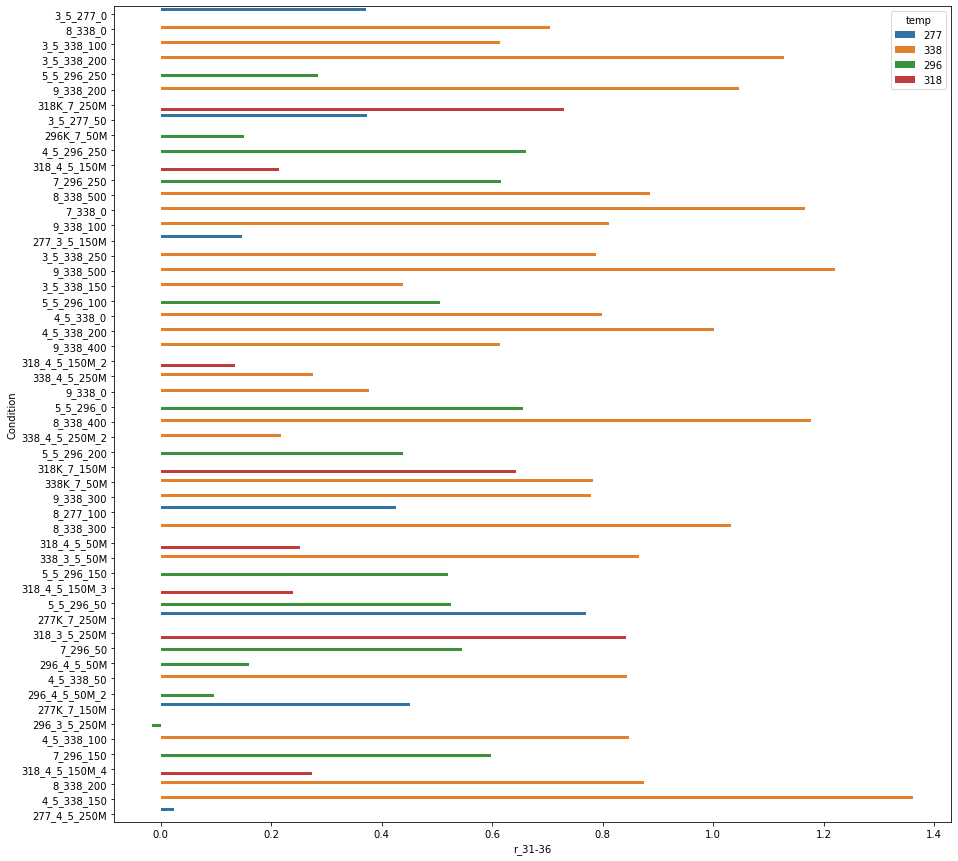

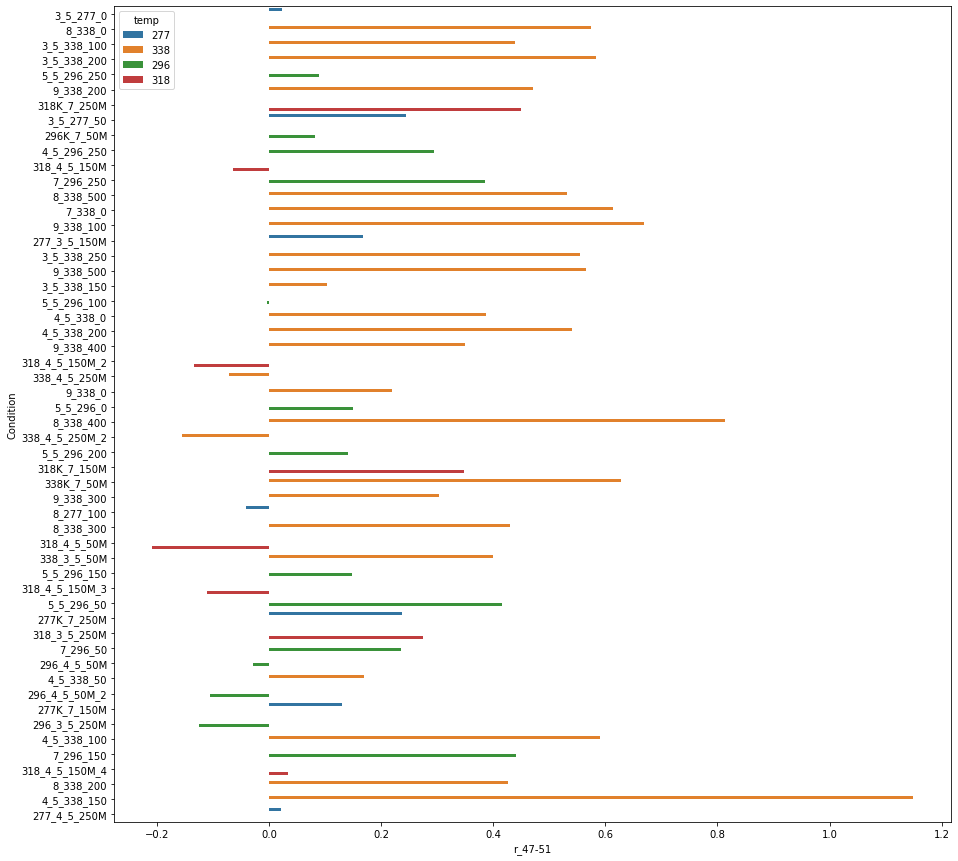

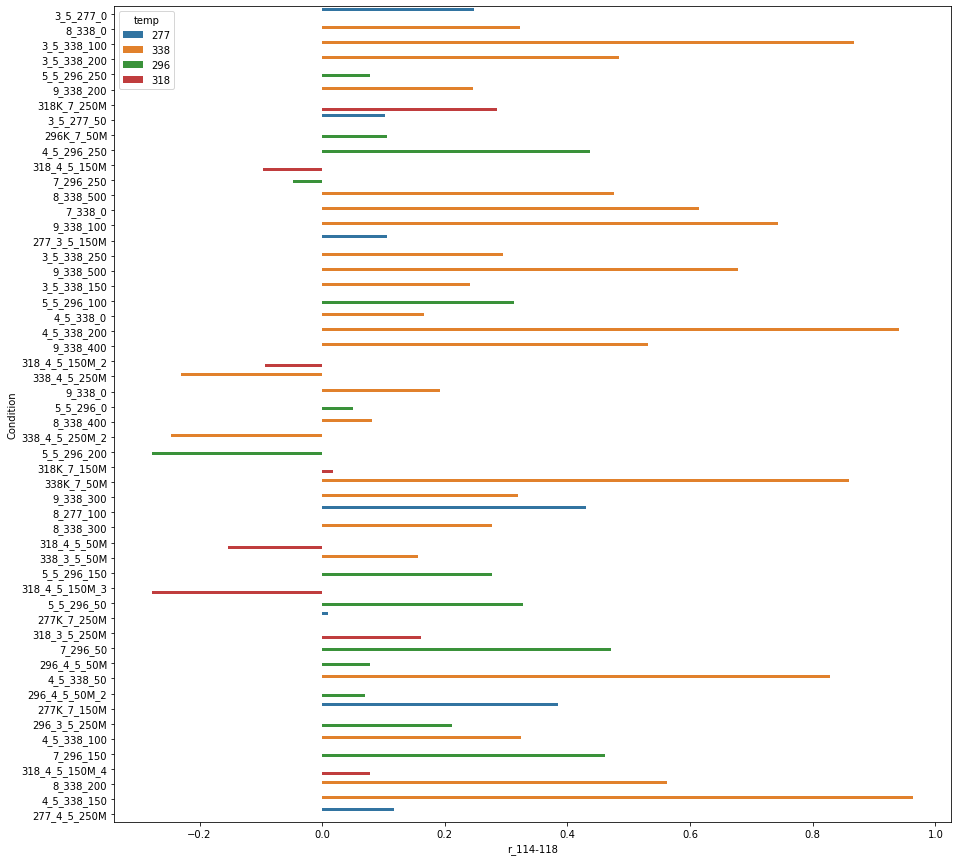

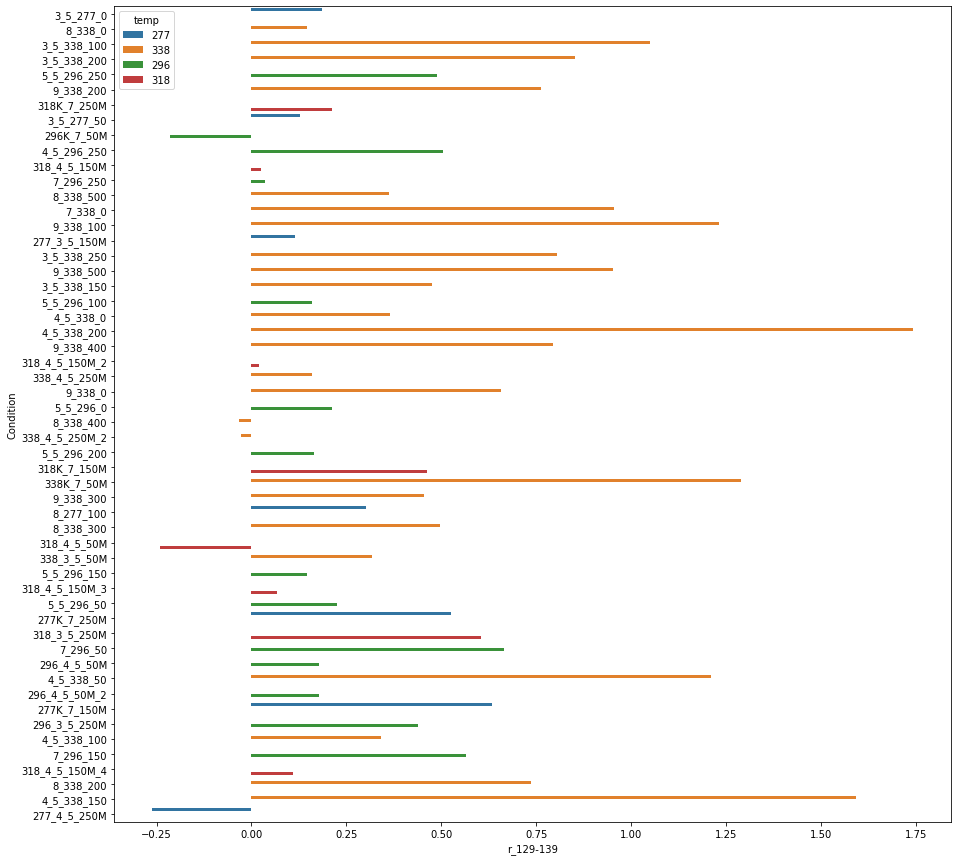

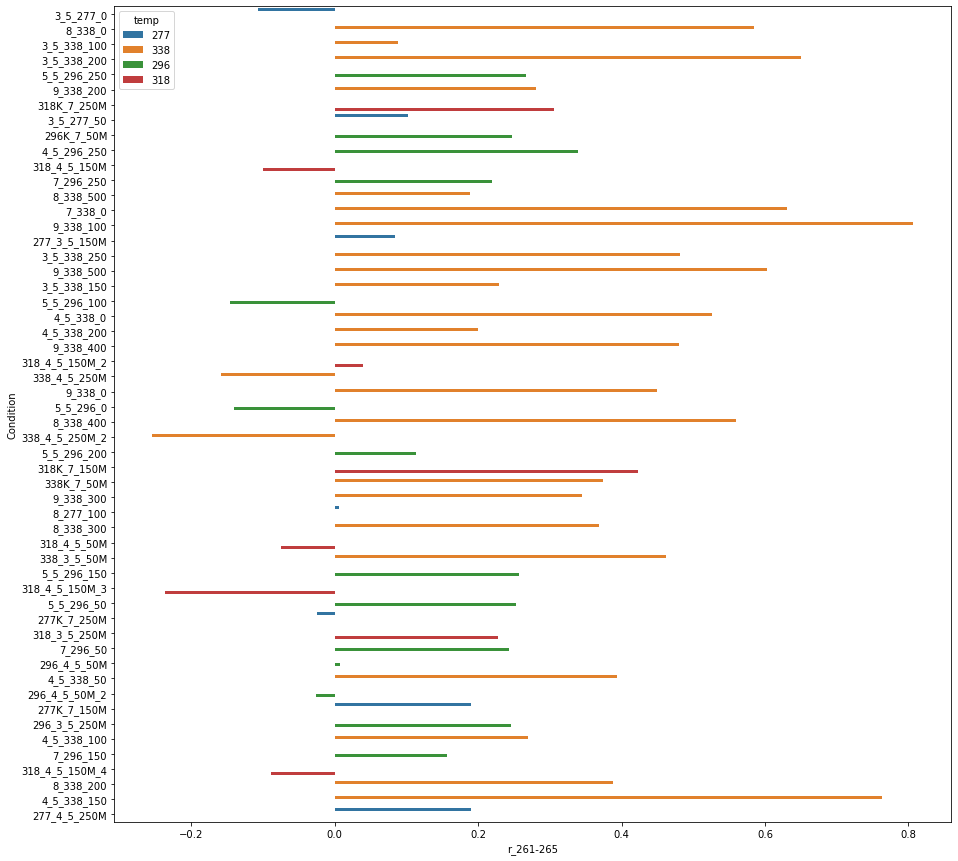

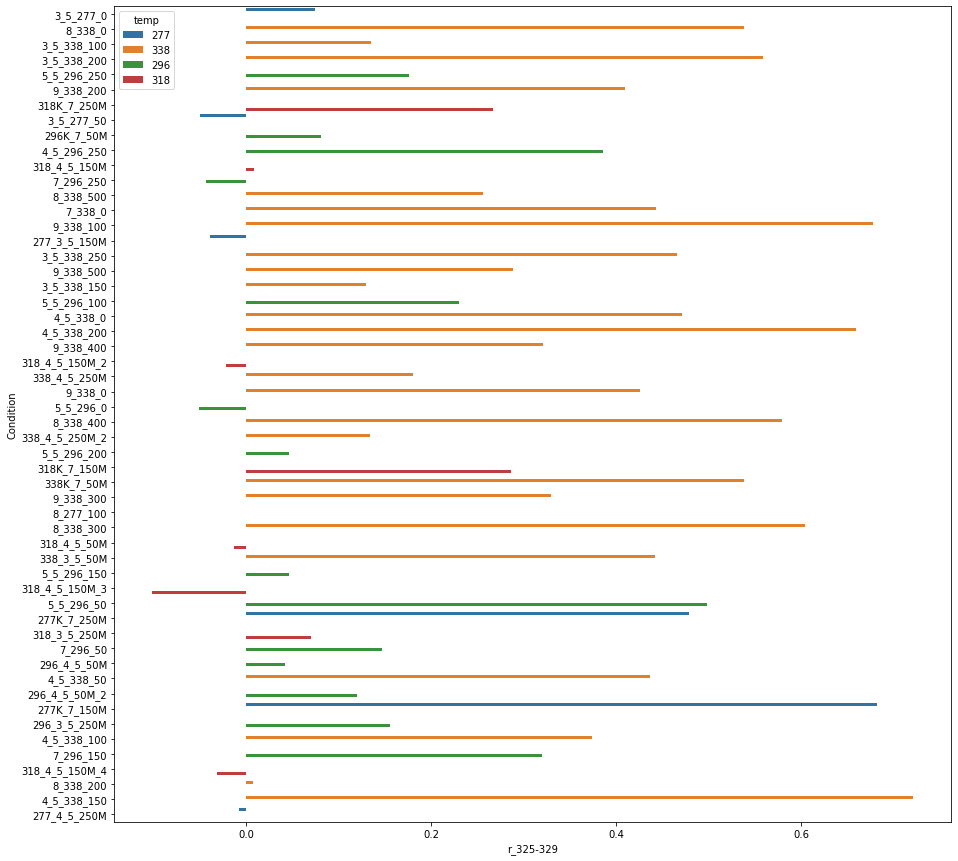

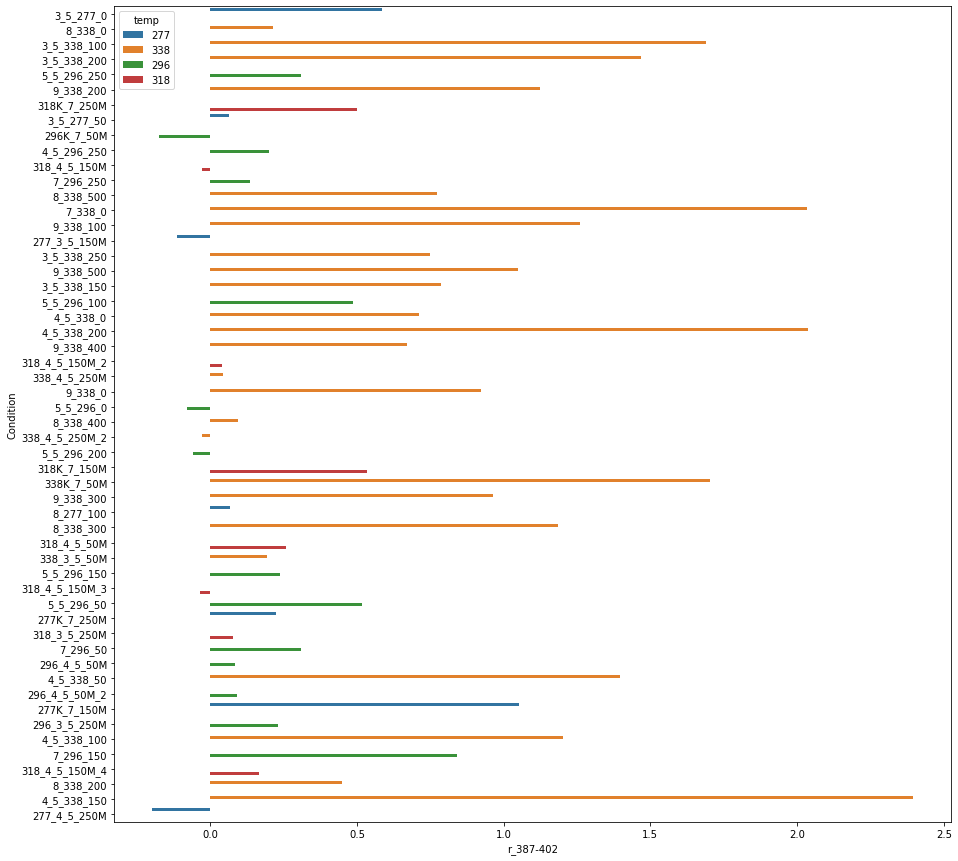

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# loop over the 7 APR regions

for i in ['r_31-36','r_47-51','r_114-118','r_129-139','r_261-265','r_325-329','r_387-402']:
    
    
    # Set the size of the plot
    plt.figure(figsize=(15, 15))

    # Create a bar plot
    sns.barplot(data=df, x=i, y='Condition',hue = 'temp')

    # Show the plot
    plt.show()

#### Colour code by pH

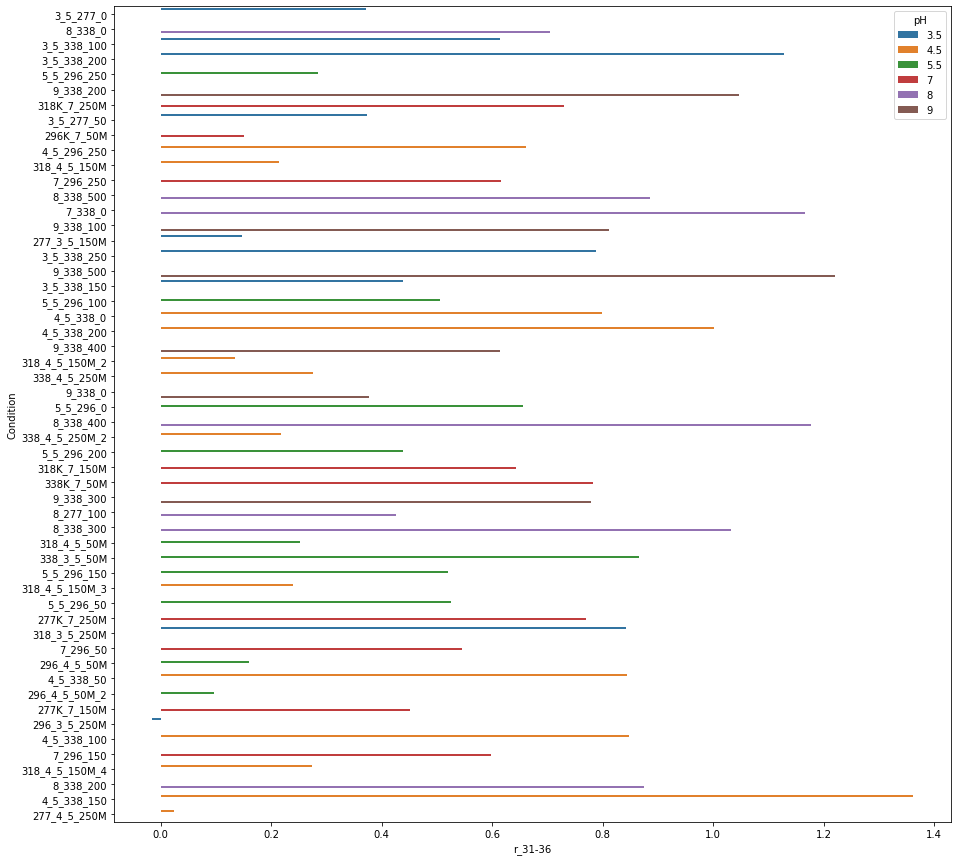

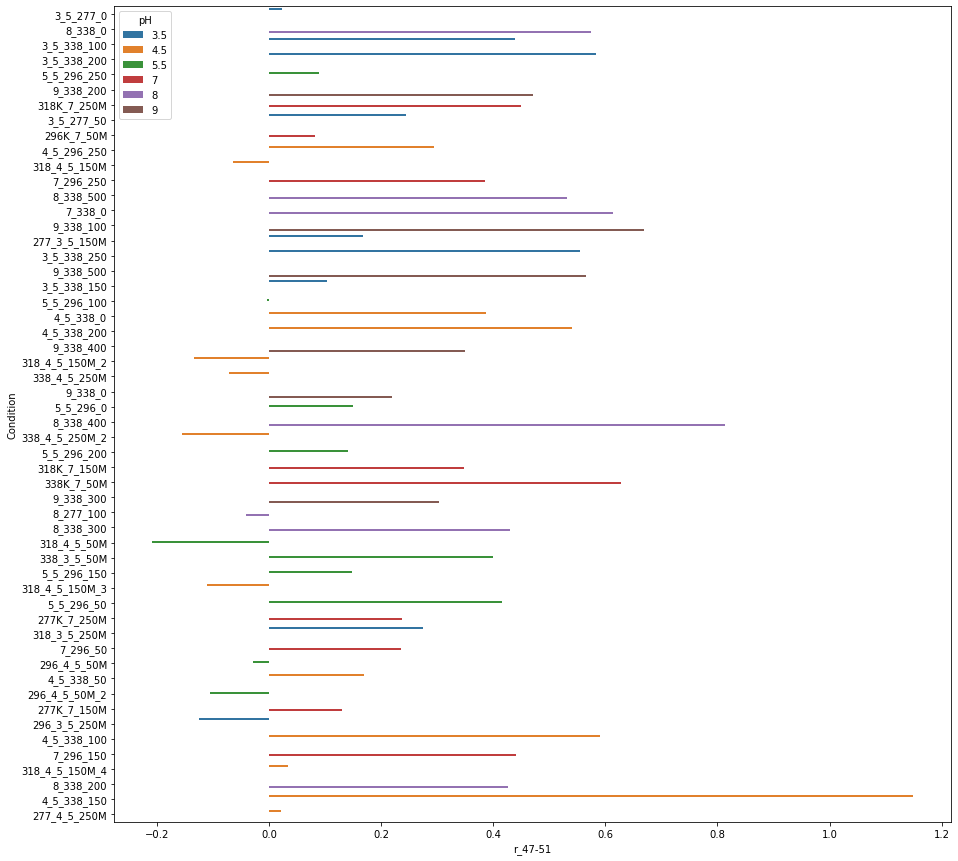

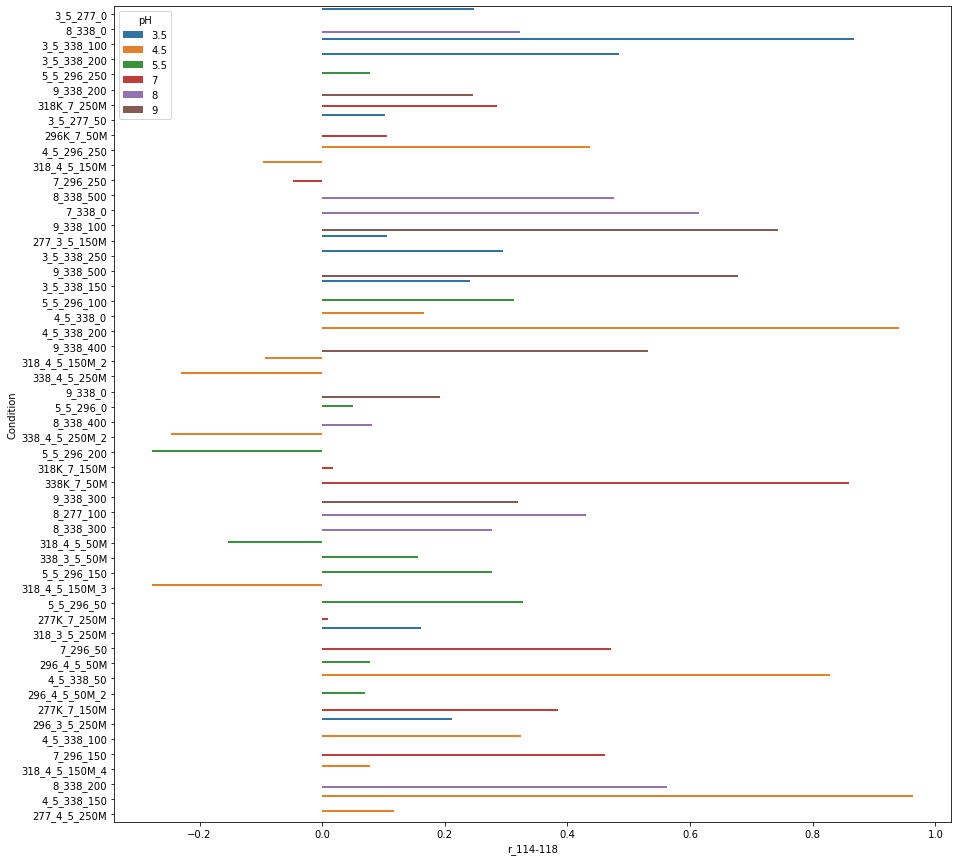

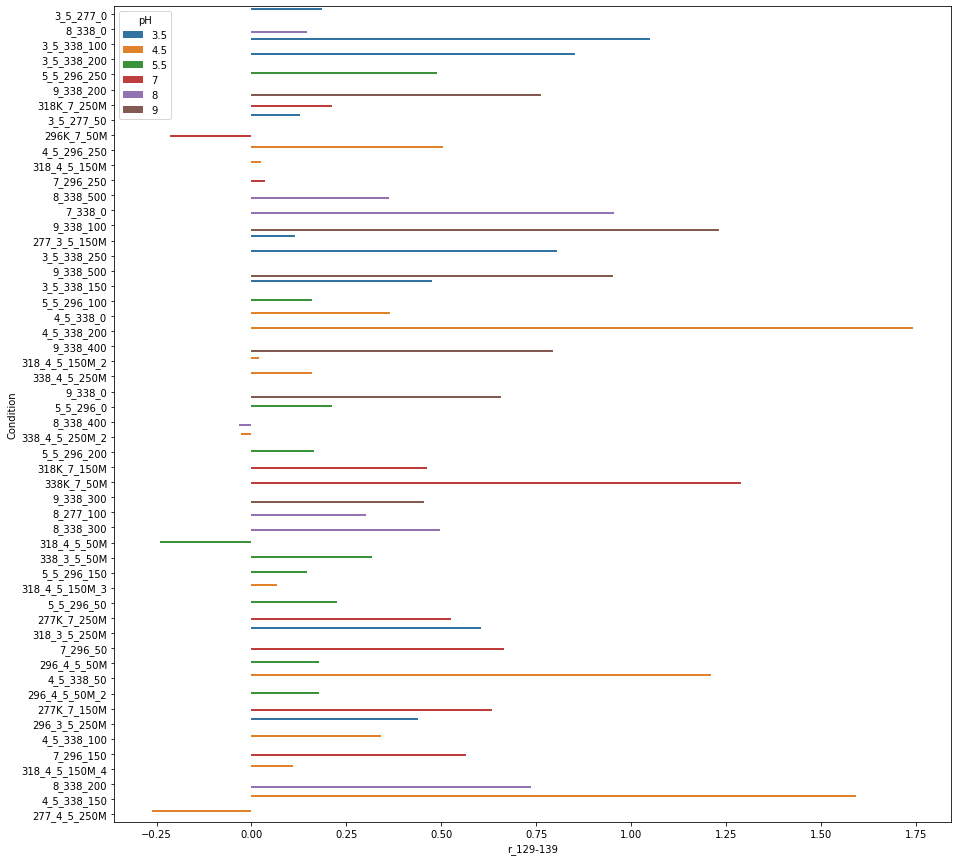

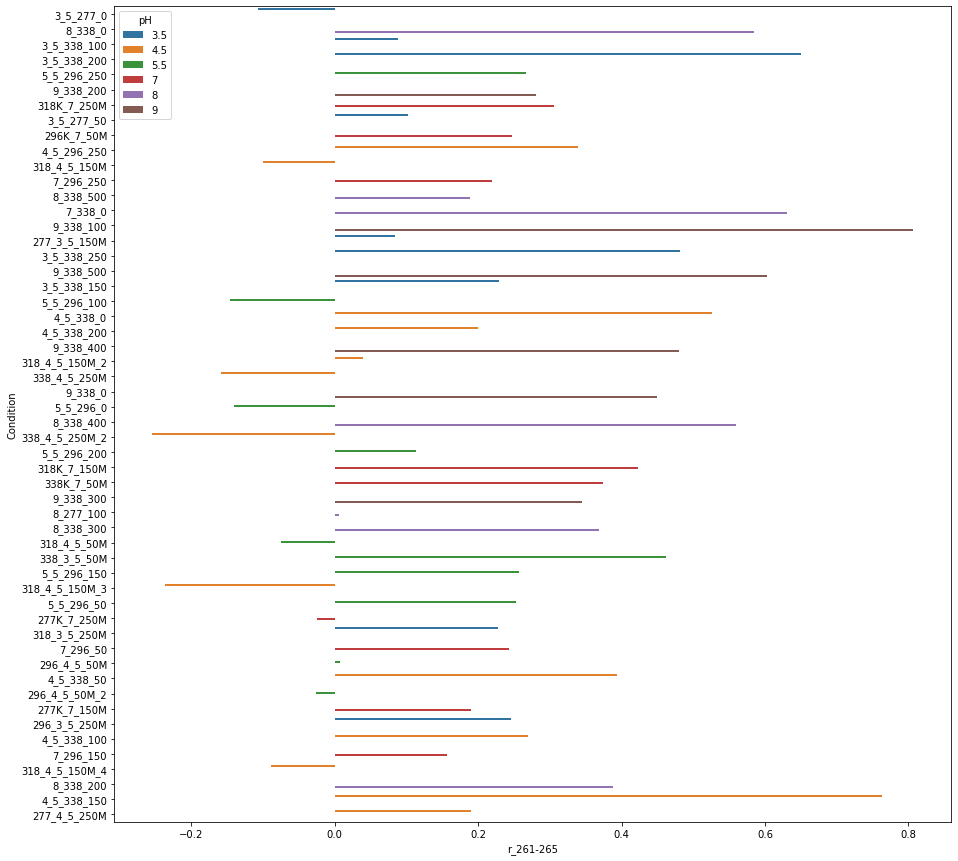

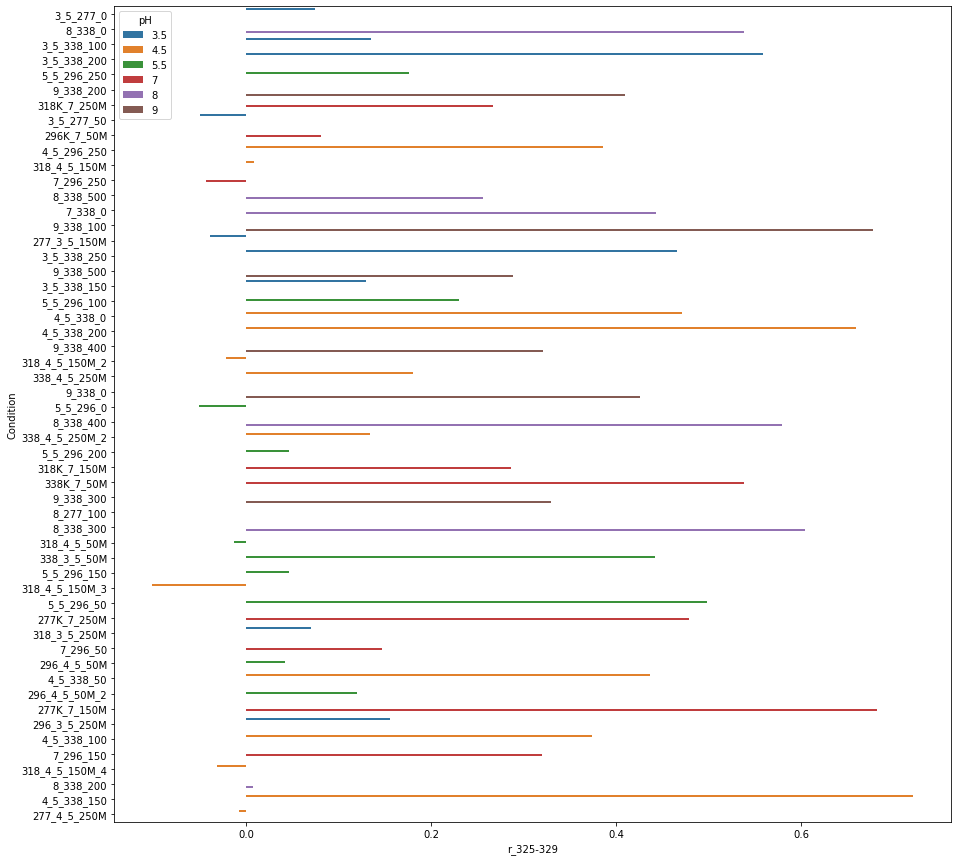

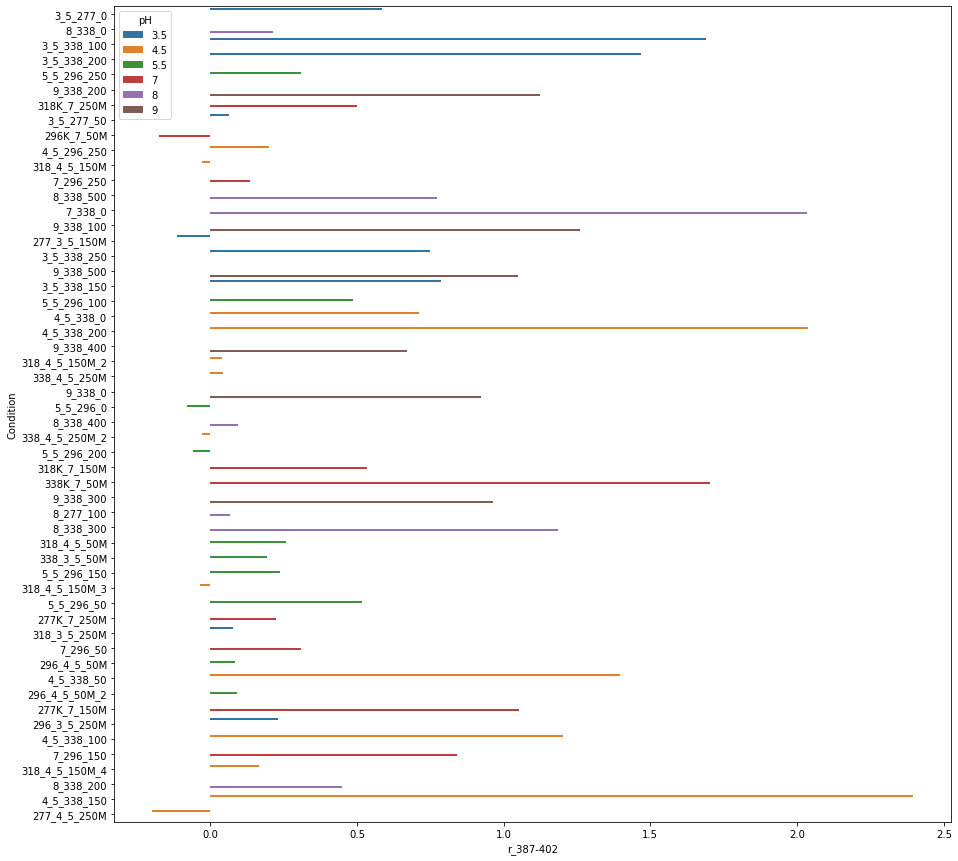

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# loop over the 7 APR regions

for i in ['r_31-36','r_47-51','r_114-118','r_129-139','r_261-265','r_325-329','r_387-402']:
    
    
    # Set the size of the plot
    plt.figure(figsize=(15, 15))

    # Create a bar plot
    sns.barplot(data=df, x=i, y='Condition',hue = 'pH')

    # Show the plot
    plt.show()

#### Colour code by IS

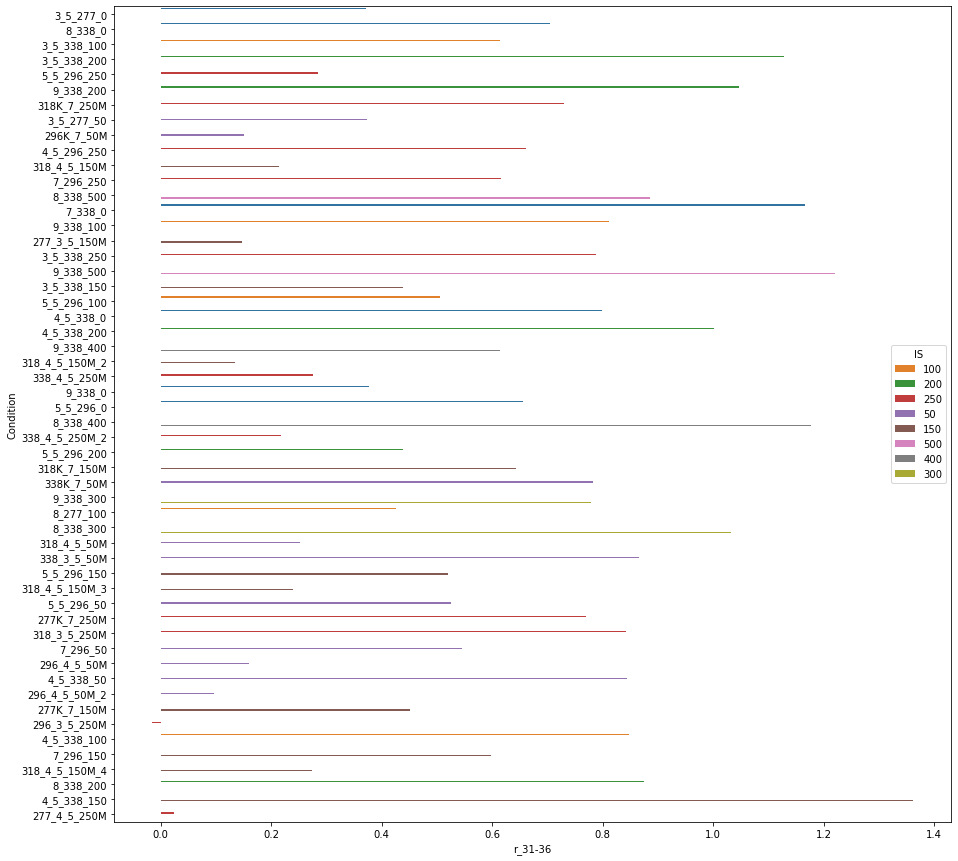

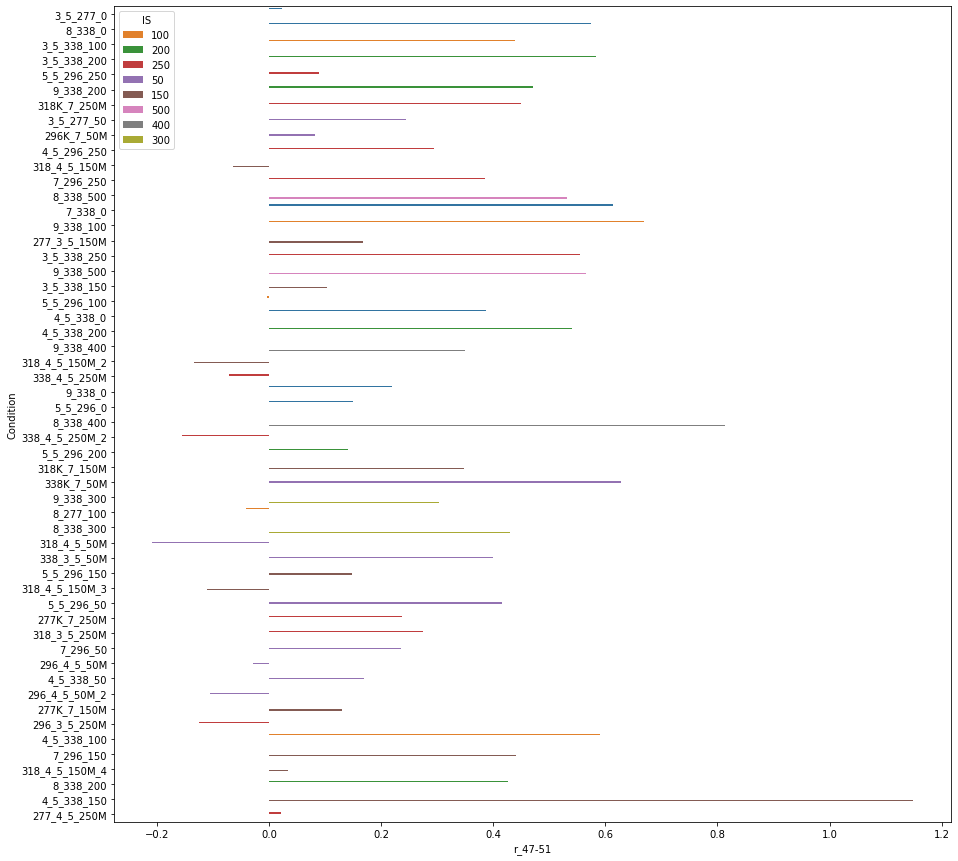

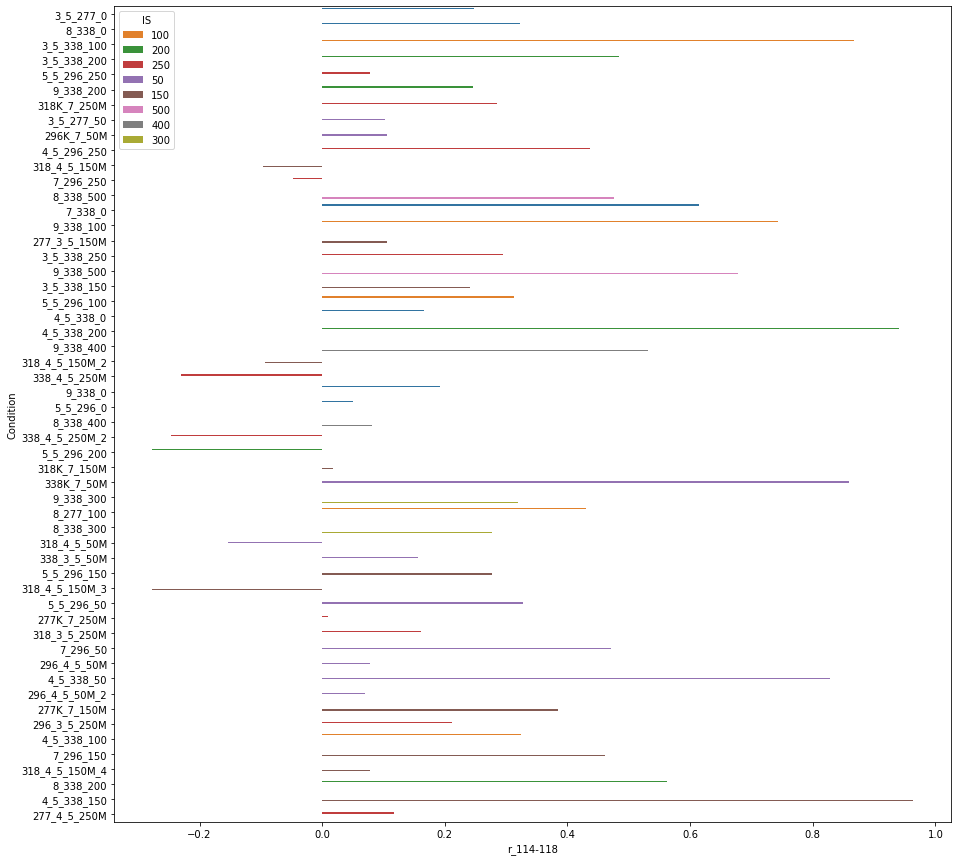

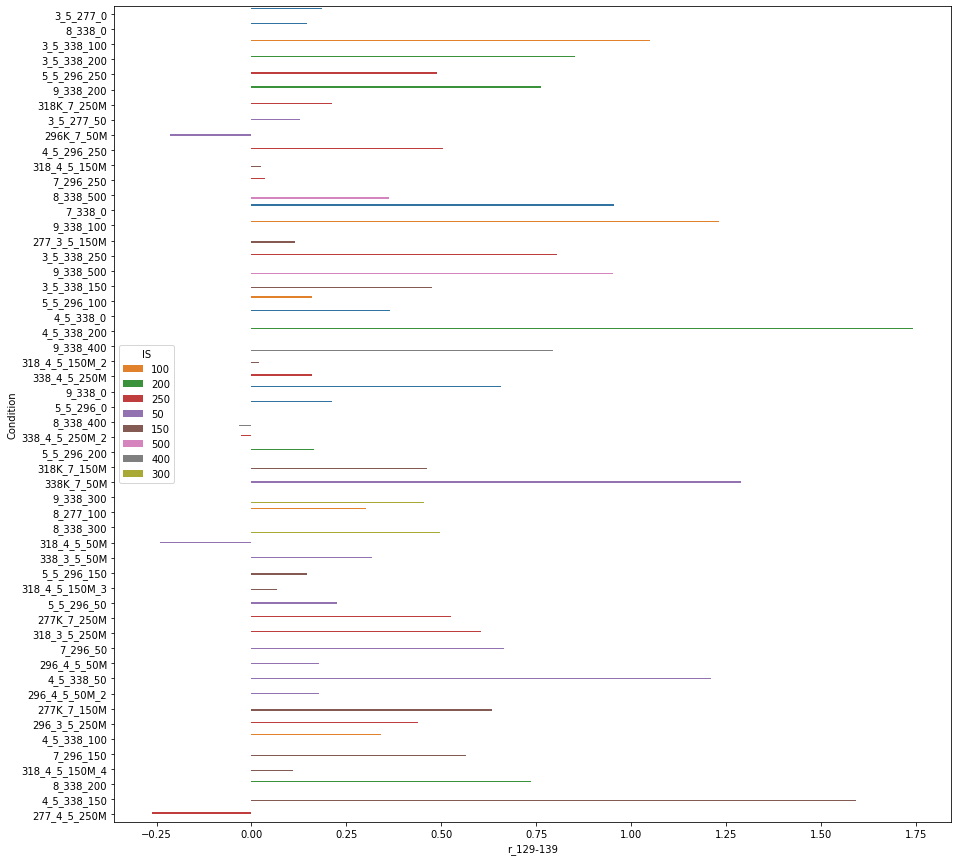

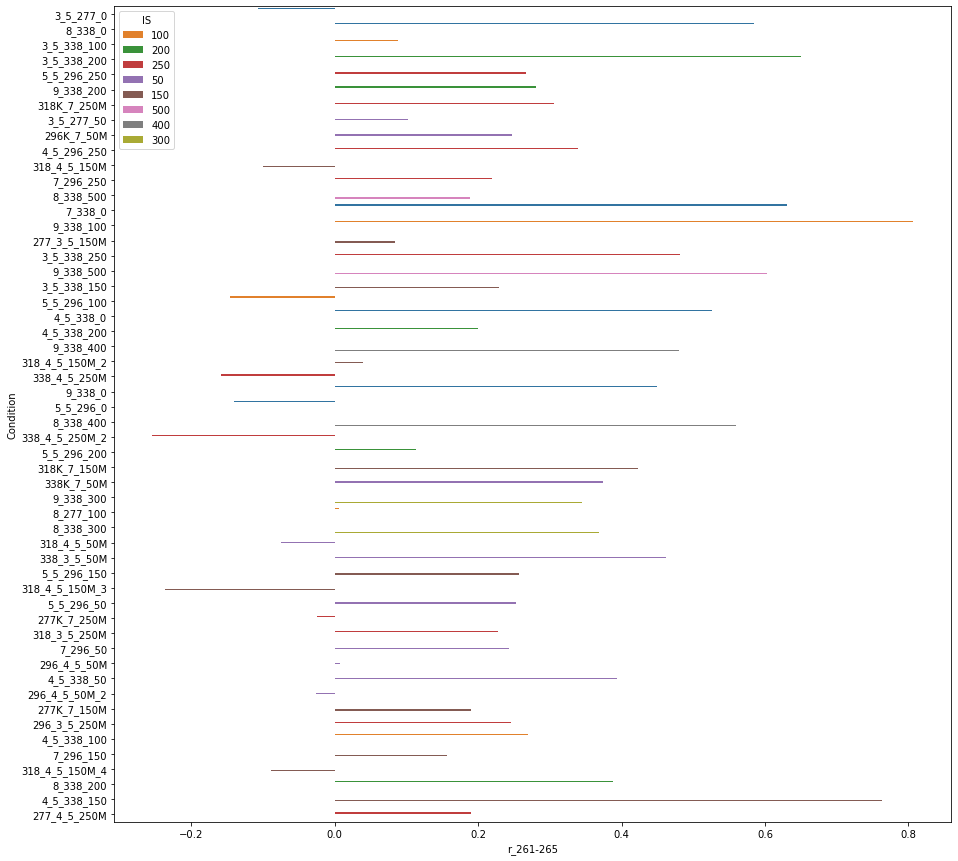

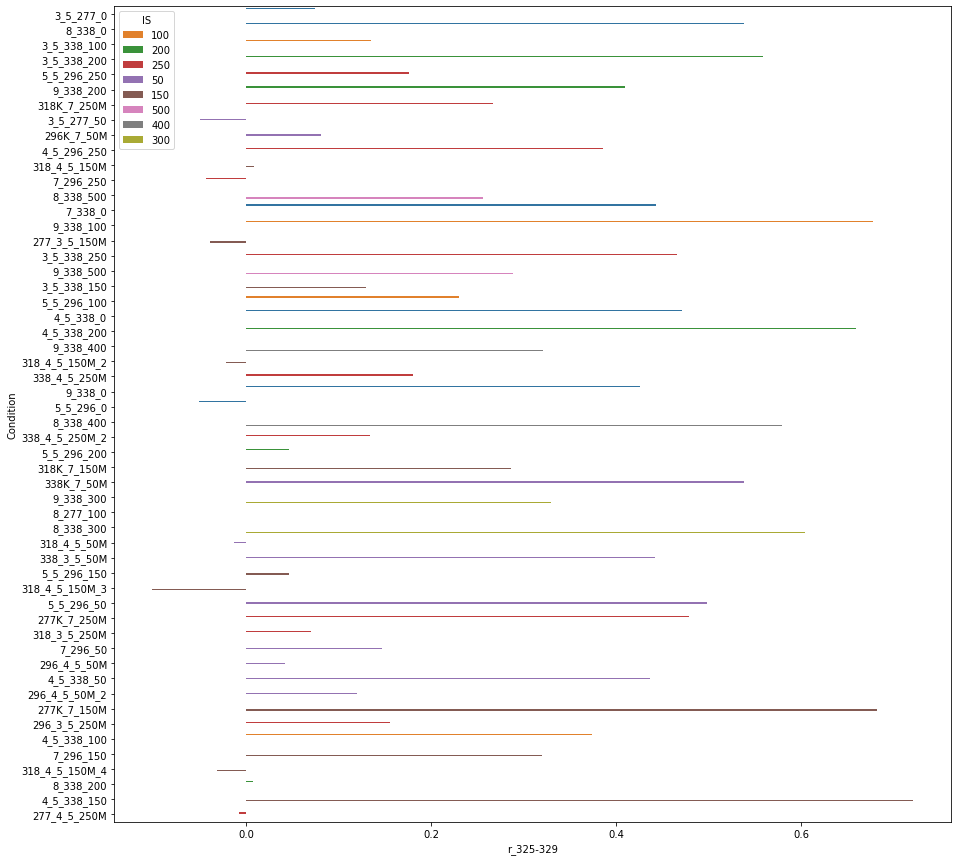

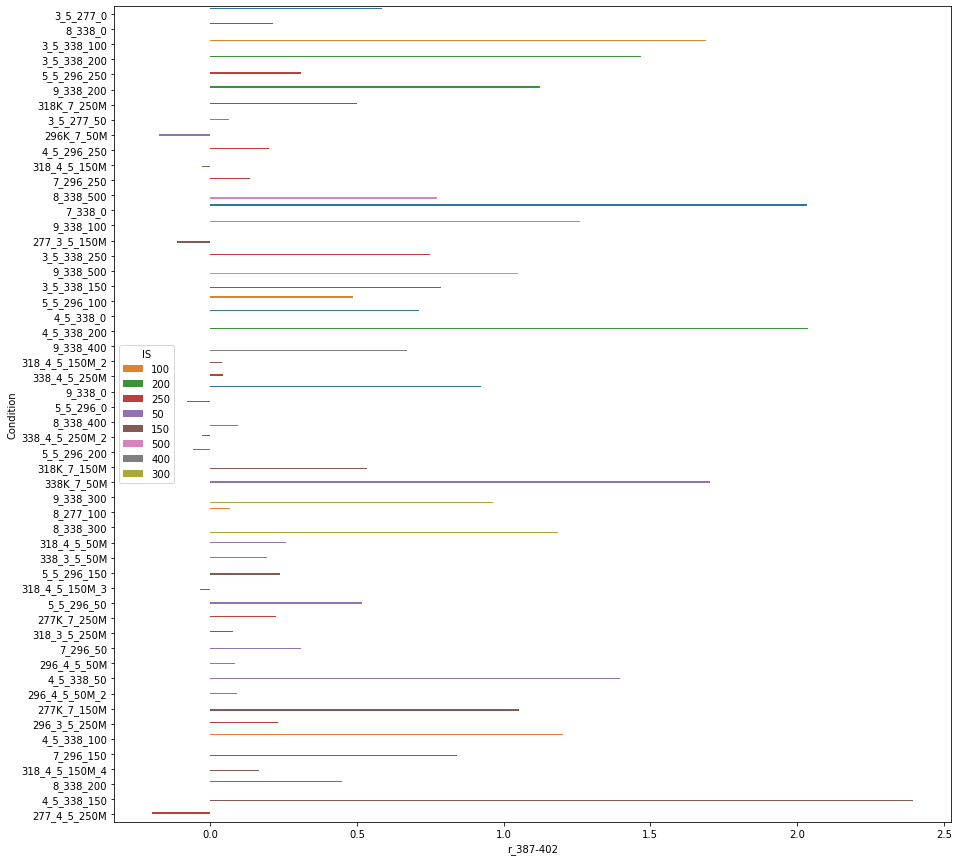

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# loop over the 7 APR regions

for i in ['r_31-36','r_47-51','r_114-118','r_129-139','r_261-265','r_325-329','r_387-402']:
    
    
    # Set the size of the plot
    plt.figure(figsize=(15, 15))

    # Create a bar plot
    sns.barplot(data=df, x=i, y='Condition',hue = 'IS')

    # Show the plot
    plt.show()